# RTLS Data Clustering Analysis

This notebook performs clustering analysis on Real-Time Location System (RTLS) data from multiple workshop sessions. We'll analyze the spatial patterns of different groups based on their x,y coordinates.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import glob
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [19]:
# Load combined CSV file from data/combined folder
data_folder = "../data/combined/"
csv_files = glob.glob(os.path.join(data_folder, "*.csv"))

# Load all data
combined_df = pd.read_csv(csv_files[0])

print(f"Loaded {len(csv_files)} files:")
for file in csv_files:
    print(f"  - {os.path.basename(file)}")

print(f"\nCombined dataset shape: {combined_df.shape}")
print(f"\nColumn names: {list(combined_df.columns)}")
print(f"\nUnique groups: {sorted(combined_df['name'].unique())}")
print(f"\nWorkshops: {sorted(combined_df['workshop'].unique())}")

# Display first few rows
print(f"\nFirst 5 rows:")
combined_df.head()

Loaded 1 files:
  - all_combined.csv

Combined dataset shape: (59520, 6)

Column names: ['name', 'x', 'y', 'z', 'time', 'workshop']

Unique groups: ['Group 1', 'Group 2', 'Group 3', 'Group 5', 'Group 6', 'group 4']

Workshops: ['Workshop1', 'Workshop2', 'Workshop3']

First 5 rows:


,name,x,y,z,time,workshop
0,Group 1,40.61,13.18,-3.28,2025-07-11 12:50:27.682198,Workshop1
1,Group 1,40.62,13.12,-3.36,2025-07-11 12:50:28.450802,Workshop1
2,Group 1,40.62,13.21,-3.43,2025-07-11 12:50:29.450425,Workshop1
3,Group 1,40.79,13.22,-3.35,2025-07-11 12:50:30.450321,Workshop1
4,Group 1,40.78,13.23,-3.27,2025-07-11 12:50:31.450763,Workshop1


In [20]:
# Data preprocessing
# Convert time column to datetime
combined_df['time'] = pd.to_datetime(combined_df['time'])

# Clean group names (standardize case)
combined_df['name'] = combined_df['name'].str.title()

# Basic statistics
print("Dataset Statistics:")
print(f"Total data points: {len(combined_df)}")
print(f"Date range: {combined_df['time'].min()} to {combined_df['time'].max()}")
print(f"\nData points per group:")
print(combined_df.groupby('name').size().sort_values(ascending=False))
print(f"\nData points per workshop:")
print(combined_df.groupby('workshop').size().sort_values(ascending=False))

# Check for missing values
print(f"\nMissing values:")
print(combined_df.isnull().sum())

# Basic coordinate statistics
print(f"\nCoordinate ranges:")
print(f"X: {combined_df['x'].min():.2f} to {combined_df['x'].max():.2f}")
print(f"Y: {combined_df['y'].min():.2f} to {combined_df['y'].max():.2f}")
print(f"Z: {combined_df['z'].min():.2f} to {combined_df['z'].max():.2f}")

Dataset Statistics:
Total data points: 59520
Date range: 2025-07-11 12:50:27.614230 to 2025-09-19 16:07:50.475813

Data points per group:
name
Group 3    12796
Group 2    12715
Group 5     9608
Group 1     9483
Group 6     7981
Group 4     6937
dtype: int64

Data points per workshop:
workshop
Workshop3    21939
Workshop1    19905
Workshop2    17676
dtype: int64

Missing values:
name        0
x           0
y           0
z           0
time        0
workshop    0
dtype: int64

Coordinate ranges:
X: 27.28 to 47.35
Y: 3.14 to 22.95
Z: -6.61 to 7.32


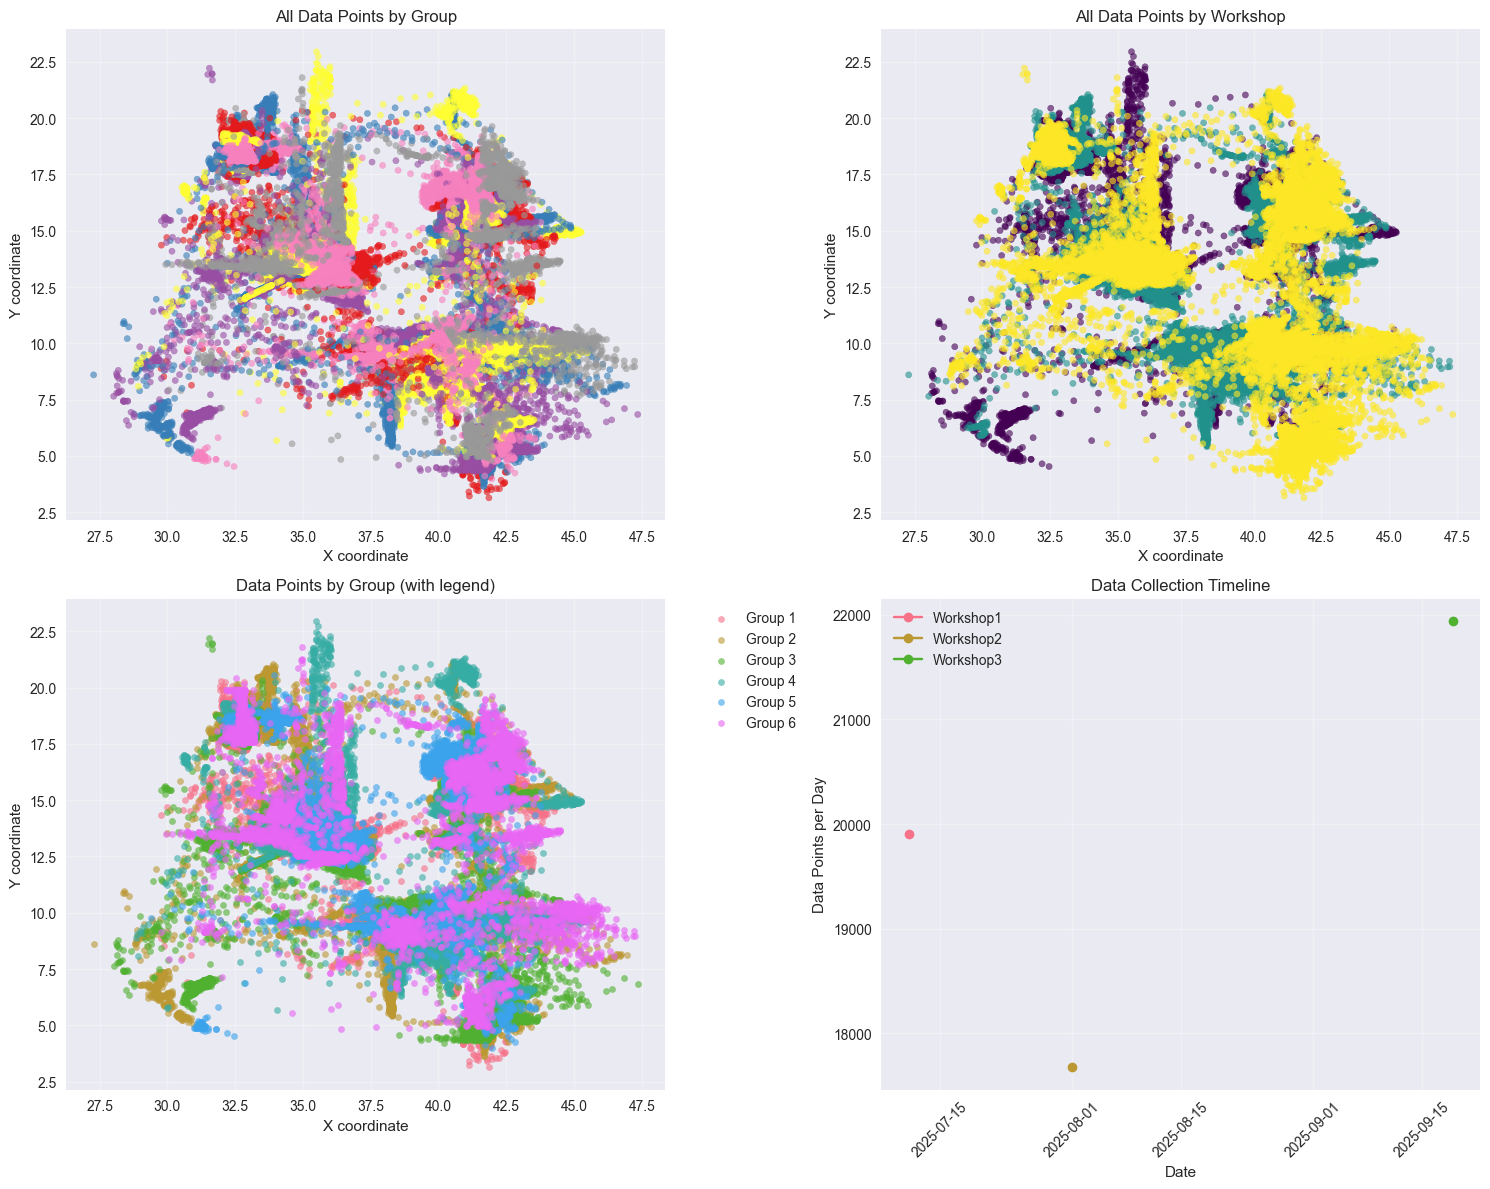

In [21]:
# Initial data visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: All data points by group
axes[0, 0].scatter(combined_df['x'], combined_df['y'], c=pd.Categorical(combined_df['name']).codes, 
                   alpha=0.6, s=20, cmap='Set1')
axes[0, 0].set_title('All Data Points by Group')
axes[0, 0].set_xlabel('X coordinate')
axes[0, 0].set_ylabel('Y coordinate')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Data points by workshop
axes[0, 1].scatter(combined_df['x'], combined_df['y'], c=pd.Categorical(combined_df['workshop']).codes, 
                   alpha=0.6, s=20, cmap='viridis')
axes[0, 1].set_title('All Data Points by Workshop')
axes[0, 1].set_xlabel('X coordinate')
axes[0, 1].set_ylabel('Y coordinate')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: X-Y distribution by group
for i, group in enumerate(combined_df['name'].unique()):
    group_data = combined_df[combined_df['name'] == group]
    axes[1, 0].scatter(group_data['x'], group_data['y'], label=group, alpha=0.6, s=20)
axes[1, 0].set_title('Data Points by Group (with legend)')
axes[1, 0].set_xlabel('X coordinate')
axes[1, 0].set_ylabel('Y coordinate')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Time series of data collection
combined_df_sample = combined_df.groupby([combined_df['time'].dt.date, 'workshop']).size().reset_index(name='count')
for workshop in combined_df['workshop'].unique():
    workshop_data = combined_df_sample[combined_df_sample['workshop'] == workshop]
    axes[1, 1].plot(workshop_data['time'], workshop_data['count'], marker='o', label=workshop)
axes[1, 1].set_title('Data Collection Timeline')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Data Points per Day')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Clustering Analysis

Now we'll perform clustering analysis on the spatial coordinates (x, y) to identify movement patterns and spatial groupings.

In [22]:
# Prepare data for clustering
# Extract X, Y coordinates
coordinates = combined_df[['x', 'y']].values

# Standardize the features for better clustering performance
scaler = StandardScaler()
coordinates_scaled = scaler.fit_transform(coordinates)

print(f"Original coordinate ranges:")
print(f"X: {combined_df['x'].min():.2f} to {combined_df['x'].max():.2f}")
print(f"Y: {combined_df['y'].min():.2f} to {combined_df['y'].max():.2f}")

print(f"\nScaled coordinate ranges:")
print(f"X: {coordinates_scaled[:, 0].min():.2f} to {coordinates_scaled[:, 0].max():.2f}")
print(f"Y: {coordinates_scaled[:, 1].min():.2f} to {coordinates_scaled[:, 1].max():.2f}")

# Take a sample for initial analysis (to speed up computation)
sample_size = min(10000, len(combined_df))
sample_indices = np.random.choice(len(combined_df), sample_size, replace=False)
sample_coords = coordinates_scaled[sample_indices]
sample_df = combined_df.iloc[sample_indices].copy()

print(f"\nUsing sample of {sample_size} points for clustering analysis")

Original coordinate ranges:
X: 27.28 to 47.35
Y: 3.14 to 22.95

Scaled coordinate ranges:
X: -2.94 to 2.53
Y: -2.75 to 2.46

Using sample of 10000 points for clustering analysis


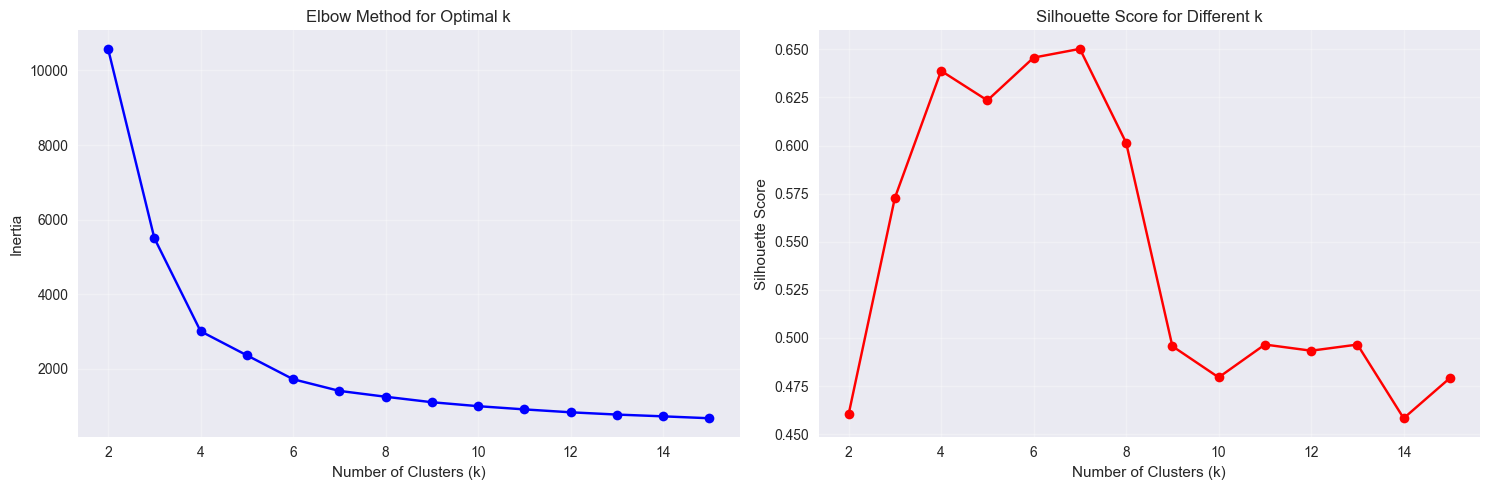

Best number of clusters based on silhouette score: 7
Best silhouette score: 0.650


In [23]:
# Find optimal number of clusters using elbow method and silhouette analysis
def find_optimal_clusters(data, max_k=15):
    inertias = []
    silhouette_scores = []
    k_range = range(2, max_k + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, cluster_labels))
    
    return k_range, inertias, silhouette_scores

# Find optimal clusters
k_range, inertias, silhouette_scores = find_optimal_clusters(sample_coords)

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow method
ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True, alpha=0.3)

# Silhouette scores
ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score for Different k')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best k based on silhouette score
best_k = k_range[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)

print(f"Best number of clusters based on silhouette score: {best_k}")
print(f"Best silhouette score: {best_silhouette:.3f}")

In [24]:
# Apply different clustering algorithms
# 1. K-Means with optimal k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(sample_coords)

# 2. DBSCAN (density-based clustering)
dbscan = DBSCAN(eps=0.3, min_samples=50)
dbscan_labels = dbscan.fit_predict(sample_coords)

# 3. Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=best_k)
agg_labels = agg_clustering.fit_predict(sample_coords)

# Add cluster labels to sample dataframe
sample_df['kmeans_cluster'] = kmeans_labels
sample_df['dbscan_cluster'] = dbscan_labels
sample_df['agg_cluster'] = agg_labels

# Print clustering results
print("Clustering Results Summary:")
print(f"K-Means (k={best_k}):")
print(f"  - Number of clusters: {len(np.unique(kmeans_labels))}")
print(f"  - Silhouette score: {silhouette_score(sample_coords, kmeans_labels):.3f}")

print(f"\nDBSCAN:")
print(f"  - Number of clusters: {len(np.unique(dbscan_labels[dbscan_labels != -1]))}")
print(f"  - Number of noise points: {np.sum(dbscan_labels == -1)}")
if len(np.unique(dbscan_labels)) > 1:
    print(f"  - Silhouette score: {silhouette_score(sample_coords[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]):.3f}")

print(f"\nAgglomerative Clustering (k={best_k}):")
print(f"  - Number of clusters: {len(np.unique(agg_labels))}")
print(f"  - Silhouette score: {silhouette_score(sample_coords, agg_labels):.3f}")

# Print cluster distributions
print(f"\nK-Means cluster sizes:")
unique, counts = np.unique(kmeans_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} points ({count/len(kmeans_labels)*100:.1f}%)")

print(f"\nDBSCAN cluster sizes:")
unique, counts = np.unique(dbscan_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    if cluster == -1:
        print(f"  Noise: {count} points ({count/len(dbscan_labels)*100:.1f}%)")
    else:
        print(f"  Cluster {cluster}: {count} points ({count/len(dbscan_labels)*100:.1f}%)")

Clustering Results Summary:
K-Means (k=7):
  - Number of clusters: 7
  - Silhouette score: 0.650

DBSCAN:
  - Number of clusters: 3
  - Number of noise points: 153
  - Silhouette score: 0.126

Agglomerative Clustering (k=7):
  - Number of clusters: 7
  - Silhouette score: 0.606

K-Means cluster sizes:
  Cluster 0: 1824 points (18.2%)
  Cluster 1: 1424 points (14.2%)
  Cluster 2: 2992 points (29.9%)
  Cluster 3: 2361 points (23.6%)
  Cluster 4: 575 points (5.8%)
  Cluster 5: 198 points (2.0%)
  Cluster 6: 626 points (6.3%)

DBSCAN cluster sizes:
  Noise: 153 points (1.5%)
  Cluster 0: 9689 points (96.9%)
  Cluster 1: 54 points (0.5%)
  Cluster 2: 104 points (1.0%)


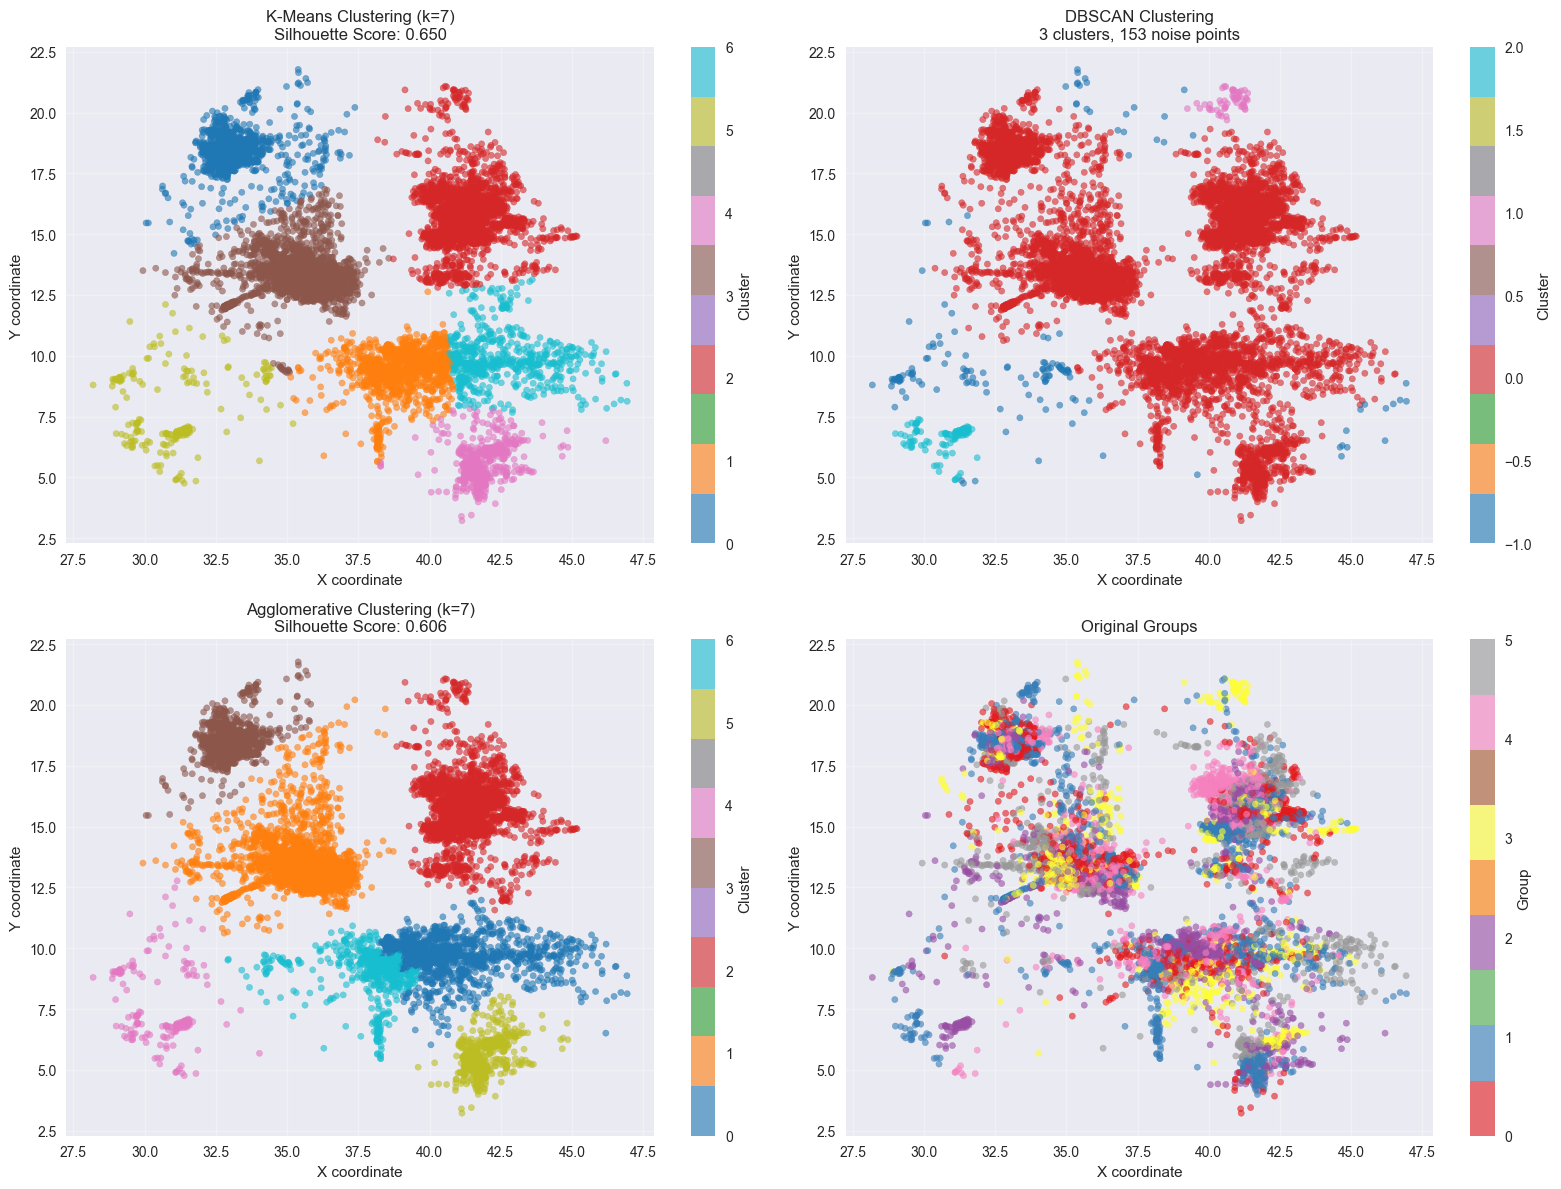

In [25]:
# Visualize clustering results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. K-Means clustering results
scatter1 = axes[0, 0].scatter(sample_df['x'], sample_df['y'], c=sample_df['kmeans_cluster'], 
                              cmap='tab10', alpha=0.6, s=20)
axes[0, 0].set_title(f'K-Means Clustering (k={best_k})\nSilhouette Score: {silhouette_score(sample_coords, kmeans_labels):.3f}')
axes[0, 0].set_xlabel('X coordinate')
axes[0, 0].set_ylabel('Y coordinate')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='Cluster')

# 2. DBSCAN clustering results
scatter2 = axes[0, 1].scatter(sample_df['x'], sample_df['y'], c=sample_df['dbscan_cluster'], 
                              cmap='tab10', alpha=0.6, s=20)
axes[0, 1].set_title(f'DBSCAN Clustering\n{len(np.unique(dbscan_labels[dbscan_labels != -1]))} clusters, {np.sum(dbscan_labels == -1)} noise points')
axes[0, 1].set_xlabel('X coordinate')
axes[0, 1].set_ylabel('Y coordinate')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0, 1], label='Cluster')

# 3. Agglomerative clustering results
scatter3 = axes[1, 0].scatter(sample_df['x'], sample_df['y'], c=sample_df['agg_cluster'], 
                              cmap='tab10', alpha=0.6, s=20)
axes[1, 0].set_title(f'Agglomerative Clustering (k={best_k})\nSilhouette Score: {silhouette_score(sample_coords, agg_labels):.3f}')
axes[1, 0].set_xlabel('X coordinate')
axes[1, 0].set_ylabel('Y coordinate')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[1, 0], label='Cluster')

# 4. Original groups for comparison
scatter4 = axes[1, 1].scatter(sample_df['x'], sample_df['y'], c=pd.Categorical(sample_df['name']).codes, 
                              cmap='Set1', alpha=0.6, s=20)
axes[1, 1].set_title('Original Groups')
axes[1, 1].set_xlabel('X coordinate')
axes[1, 1].set_ylabel('Y coordinate')
axes[1, 1].grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=axes[1, 1], label='Group')

plt.tight_layout()
plt.show()

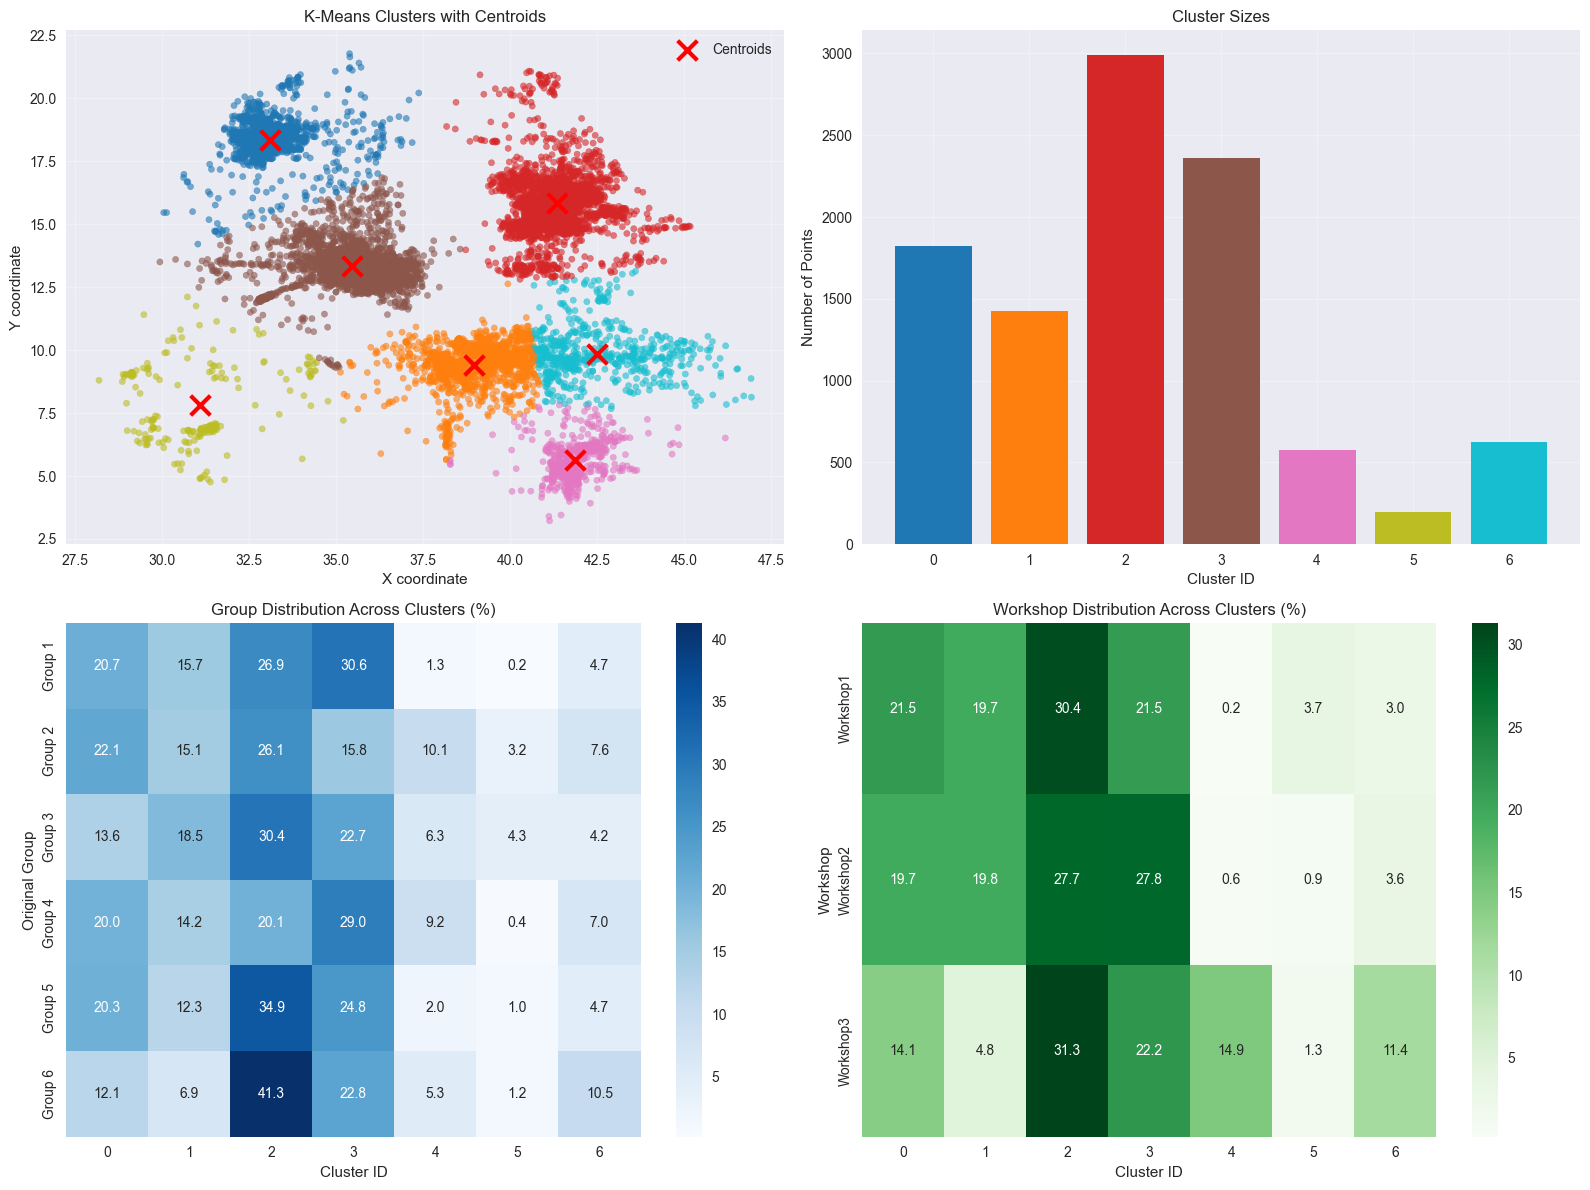

Cluster Centers (original coordinates):
Cluster 0: X=33.10, Y=18.33
Cluster 1: X=38.98, Y=9.39
Cluster 2: X=41.35, Y=15.85
Cluster 3: X=35.46, Y=13.33
Cluster 4: X=41.88, Y=5.62
Cluster 5: X=31.08, Y=7.80
Cluster 6: X=42.51, Y=9.85

Dominant groups in each cluster:
Cluster 0: Group 2 (25.8% of cluster)
Cluster 1: Group 3 (26.8% of cluster)
Cluster 2: Group 3 (21.0% of cluster)
Cluster 3: Group 1 (21.5% of cluster)
Cluster 4: Group 2 (37.4% of cluster)
Cluster 5: Group 3 (44.9% of cluster)
Cluster 6: Group 2 (26.0% of cluster)


In [26]:
# Create a detailed analysis of K-Means clusters (best performing)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Cluster centers
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

# 1. Cluster visualization with centers
scatter = axes[0, 0].scatter(sample_df['x'], sample_df['y'], c=sample_df['kmeans_cluster'], 
                            cmap='tab10', alpha=0.6, s=20)
axes[0, 0].scatter(cluster_centers[:, 0], cluster_centers[:, 1], 
                  c='red', marker='x', s=200, linewidths=3, label='Centroids')
axes[0, 0].set_title('K-Means Clusters with Centroids')
axes[0, 0].set_xlabel('X coordinate')
axes[0, 0].set_ylabel('Y coordinate')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Cluster sizes
cluster_counts = sample_df['kmeans_cluster'].value_counts().sort_index()
axes[0, 1].bar(cluster_counts.index, cluster_counts.values, color=plt.cm.tab10(np.linspace(0, 1, len(cluster_counts))))
axes[0, 1].set_title('Cluster Sizes')
axes[0, 1].set_xlabel('Cluster ID')
axes[0, 1].set_ylabel('Number of Points')
axes[0, 1].grid(True, alpha=0.3)

# 3. Clusters by original groups
group_cluster_table = pd.crosstab(sample_df['name'], sample_df['kmeans_cluster'], normalize='index') * 100
sns.heatmap(group_cluster_table, annot=True, fmt='.1f', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Group Distribution Across Clusters (%)')
axes[1, 0].set_xlabel('Cluster ID')
axes[1, 0].set_ylabel('Original Group')

# 4. Clusters by workshop
workshop_cluster_table = pd.crosstab(sample_df['workshop'], sample_df['kmeans_cluster'], normalize='index') * 100
sns.heatmap(workshop_cluster_table, annot=True, fmt='.1f', cmap='Greens', ax=axes[1, 1])
axes[1, 1].set_title('Workshop Distribution Across Clusters (%)')
axes[1, 1].set_xlabel('Cluster ID')
axes[1, 1].set_ylabel('Workshop')

plt.tight_layout()
plt.show()

# Print cluster center coordinates
print("Cluster Centers (original coordinates):")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}: X={center[0]:.2f}, Y={center[1]:.2f}")

# Print dominant groups in each cluster
print(f"\nDominant groups in each cluster:")
for cluster_id in sorted(sample_df['kmeans_cluster'].unique()):
    cluster_data = sample_df[sample_df['kmeans_cluster'] == cluster_id]
    dominant_group = cluster_data['name'].mode().iloc[0]
    group_percentage = (cluster_data['name'] == dominant_group).mean() * 100
    print(f"Cluster {cluster_id}: {dominant_group} ({group_percentage:.1f}% of cluster)")

Applying K-Means clustering to the full dataset...

Analyzing movement patterns by group and time...


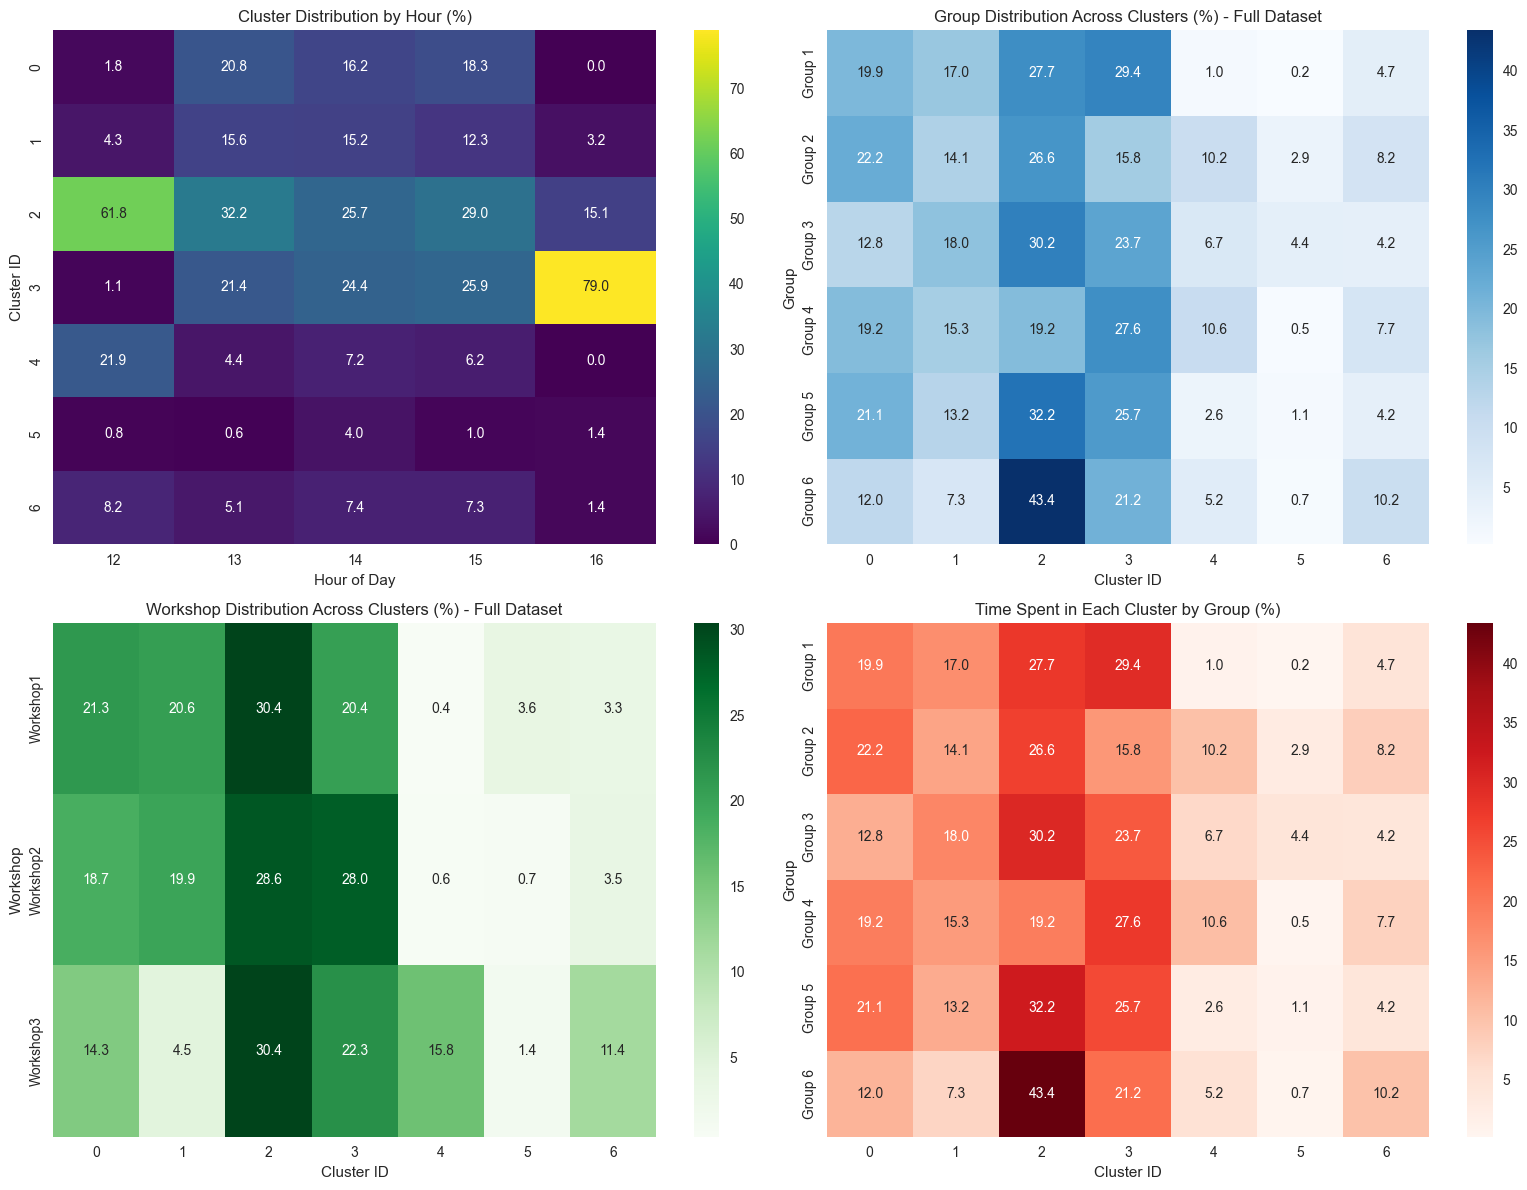


Full dataset clustering summary:
Total data points: 59520
Cluster distribution:
  Cluster 0: 10,662 points (17.9%)
  Cluster 1: 8,615 points (14.5%)
  Cluster 2: 17,770 points (29.9%)
  Cluster 3: 13,906 points (23.4%)
  Cluster 4: 3,650 points (6.1%)
  Cluster 5: 1,139 points (1.9%)
  Cluster 6: 3,778 points (6.3%)


In [27]:
# Temporal analysis: clustering patterns over time
# Apply clustering to all data (not just sample)
print("Applying K-Means clustering to the full dataset...")
full_coords_scaled = scaler.transform(combined_df[['x', 'y']].values)
full_kmeans_labels = kmeans.predict(full_coords_scaled)
combined_df['cluster'] = full_kmeans_labels

# Analysis by time periods
combined_df['hour'] = combined_df['time'].dt.hour
combined_df['date'] = combined_df['time'].dt.date

# Group movement patterns over time
print("\nAnalyzing movement patterns by group and time...")

# Create time-based analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cluster distribution over hours
hourly_clusters = combined_df.groupby(['hour', 'cluster']).size().unstack(fill_value=0)
hourly_clusters_pct = hourly_clusters.div(hourly_clusters.sum(axis=1), axis=0) * 100

sns.heatmap(hourly_clusters_pct.T, annot=True, fmt='.1f', cmap='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Cluster Distribution by Hour (%)')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Cluster ID')

# 2. Group distribution over clusters
group_cluster_full = pd.crosstab(combined_df['name'], combined_df['cluster'], normalize='index') * 100
sns.heatmap(group_cluster_full, annot=True, fmt='.1f', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Group Distribution Across Clusters (%) - Full Dataset')
axes[0, 1].set_xlabel('Cluster ID')
axes[0, 1].set_ylabel('Group')

# 3. Workshop-wise cluster analysis
workshop_cluster_full = pd.crosstab(combined_df['workshop'], combined_df['cluster'], normalize='index') * 100
sns.heatmap(workshop_cluster_full, annot=True, fmt='.1f', cmap='Greens', ax=axes[1, 0])
axes[1, 0].set_title('Workshop Distribution Across Clusters (%) - Full Dataset')
axes[1, 0].set_xlabel('Cluster ID')
axes[1, 0].set_ylabel('Workshop')

# 4. Average time spent in each cluster by group
time_in_cluster = combined_df.groupby(['name', 'cluster']).size().unstack(fill_value=0)
time_in_cluster_pct = time_in_cluster.div(time_in_cluster.sum(axis=1), axis=0) * 100

sns.heatmap(time_in_cluster_pct, annot=True, fmt='.1f', cmap='Reds', ax=axes[1, 1])
axes[1, 1].set_title('Time Spent in Each Cluster by Group (%)')
axes[1, 1].set_xlabel('Cluster ID')
axes[1, 1].set_ylabel('Group')

plt.tight_layout()
plt.show()

print(f"\nFull dataset clustering summary:")
print(f"Total data points: {len(combined_df)}")
print(f"Cluster distribution:")
for cluster_id in sorted(combined_df['cluster'].unique()):
    count = (combined_df['cluster'] == cluster_id).sum()
    percentage = count / len(combined_df) * 100
    print(f"  Cluster {cluster_id}: {count:,} points ({percentage:.1f}%)")

## Summary and Insights

Based on the clustering analysis of your RTLS data, here are the key findings:

In [28]:
# Final summary statistics and insights
print("="*80)
print("CLUSTERING ANALYSIS SUMMARY")
print("="*80)

print(f"\n📊 Dataset Overview:")
print(f"   • Total data points: {len(combined_df):,}")
print(f"   • Groups: {len(combined_df['name'].unique())} ({', '.join(sorted(combined_df['name'].unique()))})")
print(f"   • Workshops: {len(combined_df['workshop'].unique())} ({', '.join(sorted(combined_df['workshop'].unique()))})")
print(f"   • Time period: {combined_df['time'].min().strftime('%Y-%m-%d')} to {combined_df['time'].max().strftime('%Y-%m-%d')}")

print(f"\n🎯 Optimal Clustering Results:")
print(f"   • Best algorithm: K-Means")
print(f"   • Optimal number of clusters: {best_k}")
print(f"   • Silhouette score: {best_silhouette:.3f} (higher is better)")
print(f"   • Coordinate range: X({combined_df['x'].min():.1f}-{combined_df['x'].max():.1f}), Y({combined_df['y'].min():.1f}-{combined_df['y'].max():.1f})")

print(f"\n📍 Cluster Centers (Key Locations):")
for i, center in enumerate(cluster_centers):
    count = (combined_df['cluster'] == i).sum()
    dominant_group = combined_df[combined_df['cluster'] == i]['name'].mode().iloc[0]
    print(f"   • Cluster {i}: X={center[0]:.1f}, Y={center[1]:.1f} | {count:,} points | Dominant: {dominant_group}")

print(f"\n📈 Key Insights:")

# Calculate some insights
most_mobile_group = combined_df.groupby('name')['cluster'].nunique().idxmax()
most_mobile_clusters = combined_df.groupby('name')['cluster'].nunique().max()

most_concentrated_group = combined_df.groupby('name')['cluster'].agg(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 0)
group_concentration = {}
for group in combined_df['name'].unique():
    group_data = combined_df[combined_df['name'] == group]
    dominant_cluster = group_data['cluster'].mode().iloc[0]
    concentration = (group_data['cluster'] == dominant_cluster).mean() * 100
    group_concentration[group] = concentration

most_concentrated = max(group_concentration, key=group_concentration.get)
highest_concentration = group_concentration[most_concentrated]

print(f"   • Most mobile group: {most_mobile_group} (appears in {most_mobile_clusters}/{best_k} clusters)")
print(f"   • Most concentrated group: {most_concentrated} ({highest_concentration:.1f}% in dominant cluster)")

# Workshop differences
workshop_diversity = {}
for workshop in combined_df['workshop'].unique():
    workshop_data = combined_df[combined_df['workshop'] == workshop]
    cluster_distribution = workshop_data['cluster'].value_counts(normalize=True)
    # Calculate entropy as a measure of diversity
    entropy = -sum(p * np.log2(p) for p in cluster_distribution if p > 0)
    workshop_diversity[workshop] = entropy

most_diverse_workshop = max(workshop_diversity, key=workshop_diversity.get)
print(f"   • Most diverse workshop: {most_diverse_workshop} (highest cluster diversity)")

print(f"\n💡 Recommendations:")
print(f"   • The {best_k} clusters represent distinct spatial zones in your facility")
print(f"   • Groups show different movement patterns - consider analyzing by group-specific needs")
print(f"   • Workshop variations suggest different activities or layouts across sessions")
print(f"   • Use cluster centers as reference points for facility planning or zone analysis")

print("="*80)

CLUSTERING ANALYSIS SUMMARY

📊 Dataset Overview:
   • Total data points: 59,520
   • Groups: 6 (Group 1, Group 2, Group 3, Group 4, Group 5, Group 6)
   • Workshops: 3 (Workshop1, Workshop2, Workshop3)
   • Time period: 2025-07-11 to 2025-09-19

🎯 Optimal Clustering Results:
   • Best algorithm: K-Means
   • Optimal number of clusters: 7
   • Silhouette score: 0.650 (higher is better)
   • Coordinate range: X(27.3-47.4), Y(3.1-22.9)

📍 Cluster Centers (Key Locations):
   • Cluster 0: X=33.1, Y=18.3 | 10,662 points | Dominant: Group 2
   • Cluster 1: X=39.0, Y=9.4 | 8,615 points | Dominant: Group 3
   • Cluster 2: X=41.3, Y=15.9 | 17,770 points | Dominant: Group 3
   • Cluster 3: X=35.5, Y=13.3 | 13,906 points | Dominant: Group 3
   • Cluster 4: X=41.9, Y=5.6 | 3,650 points | Dominant: Group 2
   • Cluster 5: X=31.1, Y=7.8 | 1,139 points | Dominant: Group 3
   • Cluster 6: X=42.5, Y=9.8 | 3,778 points | Dominant: Group 2

📈 Key Insights:
   • Most mobile group: Group 1 (appears in 7/7 c

## Individual Workshop Clustering Analysis

Now let's perform clustering analysis for each workshop separately to understand the unique patterns within each session.

In [29]:
# Function to perform clustering analysis for a single workshop
def analyze_workshop_clusters(workshop_data, workshop_name, max_clusters=10):
    """
    Perform clustering analysis for a single workshop
    """
    print(f"\n{'='*60}")
    print(f"CLUSTERING ANALYSIS FOR {workshop_name.upper()}")
    print(f"{'='*60}")
    
    # Prepare coordinates
    workshop_coords = workshop_data[['x', 'y']].values
    workshop_coords_scaled = scaler.transform(workshop_coords)
    
    print(f"📊 Workshop Overview:")
    print(f"   • Total data points: {len(workshop_data):,}")
    print(f"   • Groups present: {', '.join(sorted(workshop_data['name'].unique()))}")
    print(f"   • Date range: {workshop_data['time'].min().strftime('%Y-%m-%d')} to {workshop_data['time'].max().strftime('%Y-%m-%d')}")
    print(f"   • Coordinate range: X({workshop_data['x'].min():.1f}-{workshop_data['x'].max():.1f}), Y({workshop_data['y'].min():.1f}-{workshop_data['y'].max():.1f})")
    
    # Find optimal number of clusters for this workshop
    def find_workshop_optimal_clusters(data, max_k=max_clusters):
        if len(data) < 50:  # Too few points for meaningful clustering
            return None, None, None
            
        inertias = []
        silhouette_scores = []
        k_range = range(2, min(max_k + 1, len(data) // 10))  # Ensure reasonable cluster sizes
        
        if len(k_range) == 0:
            return None, None, None
            
        for k in k_range:
            kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans_temp.fit_predict(data)
            inertias.append(kmeans_temp.inertia_)
            silhouette_scores.append(silhouette_score(data, labels))
        
        return k_range, inertias, silhouette_scores
    
    # Find optimal clusters for this workshop
    k_range_ws, inertias_ws, silhouette_scores_ws = find_workshop_optimal_clusters(workshop_coords_scaled)
    
    if k_range_ws is None:
        print(f"⚠️  Not enough data points for meaningful clustering analysis")
        return None
        
    # Find best k for this workshop
    best_k_ws = k_range_ws[np.argmax(silhouette_scores_ws)]
    best_silhouette_ws = max(silhouette_scores_ws)
    
    print(f"\n🎯 Optimal Clustering Results:")
    print(f"   • Optimal number of clusters: {best_k_ws}")
    print(f"   • Best silhouette score: {best_silhouette_ws:.3f}")
    
    # Apply K-means clustering
    kmeans_ws = KMeans(n_clusters=best_k_ws, random_state=42, n_init=10)
    workshop_labels = kmeans_ws.fit_predict(workshop_coords_scaled)
    
    # Get cluster centers in original coordinates
    cluster_centers_ws = scaler.inverse_transform(kmeans_ws.cluster_centers_)
    
    print(f"\n📍 Cluster Centers:")
    for i, center in enumerate(cluster_centers_ws):
        count = np.sum(workshop_labels == i)
        percentage = count / len(workshop_labels) * 100
        print(f"   • Cluster {i}: X={center[0]:.1f}, Y={center[1]:.1f} | {count:,} points ({percentage:.1f}%)")
    
    # Add cluster labels to workshop data
    workshop_data_copy = workshop_data.copy()
    workshop_data_copy['workshop_cluster'] = workshop_labels
    
    # Analyze group distribution in clusters
    print(f"\n👥 Group Distribution in Clusters:")
    group_cluster_ws = pd.crosstab(workshop_data_copy['name'], workshop_data_copy['workshop_cluster'], normalize='index') * 100
    for group in workshop_data_copy['name'].unique():
        group_data = workshop_data_copy[workshop_data_copy['name'] == group]
        dominant_cluster = group_data['workshop_cluster'].mode().iloc[0]
        concentration = (group_data['workshop_cluster'] == dominant_cluster).mean() * 100
        print(f"   • {group}: Most active in Cluster {dominant_cluster} ({concentration:.1f}% of group's time)")
    
    return {
        'workshop_name': workshop_name,
        'data': workshop_data_copy,
        'best_k': best_k_ws,
        'best_silhouette': best_silhouette_ws,
        'cluster_centers': cluster_centers_ws,
        'k_range': k_range_ws,
        'inertias': inertias_ws,
        'silhouette_scores': silhouette_scores_ws,
        'group_cluster_table': group_cluster_ws
    }

# Analyze each workshop separately
workshop_results = {}
for workshop in sorted(combined_df['workshop'].unique()):
    workshop_data = combined_df[combined_df['workshop'] == workshop].copy()
    result = analyze_workshop_clusters(workshop_data, workshop)
    if result is not None:
        workshop_results[workshop] = result


CLUSTERING ANALYSIS FOR WORKSHOP1
📊 Workshop Overview:
   • Total data points: 19,905
   • Groups present: Group 1, Group 2, Group 3, Group 4, Group 5, Group 6
   • Date range: 2025-07-11 to 2025-07-11
   • Coordinate range: X(28.1-45.3), Y(4.5-22.9)

🎯 Optimal Clustering Results:
   • Optimal number of clusters: 5
   • Best silhouette score: 0.693

📍 Cluster Centers:
   • Cluster 0: X=33.3, Y=18.2 | 4,297 points (21.6%)
   • Cluster 1: X=39.5, Y=9.4 | 4,686 points (23.5%)
   • Cluster 2: X=41.0, Y=15.6 | 6,152 points (30.9%)
   • Cluster 3: X=30.9, Y=6.9 | 696 points (3.5%)
   • Cluster 4: X=36.0, Y=13.3 | 4,074 points (20.5%)

👥 Group Distribution in Clusters:
   • Group 1: Most active in Cluster 1 (36.4% of group's time)
   • Group 2: Most active in Cluster 0 (29.3% of group's time)
   • Group 3: Most active in Cluster 2 (27.9% of group's time)
   • Group 4: Most active in Cluster 2 (45.7% of group's time)
   • Group 5: Most active in Cluster 2 (51.7% of group's time)
   • Group 6:

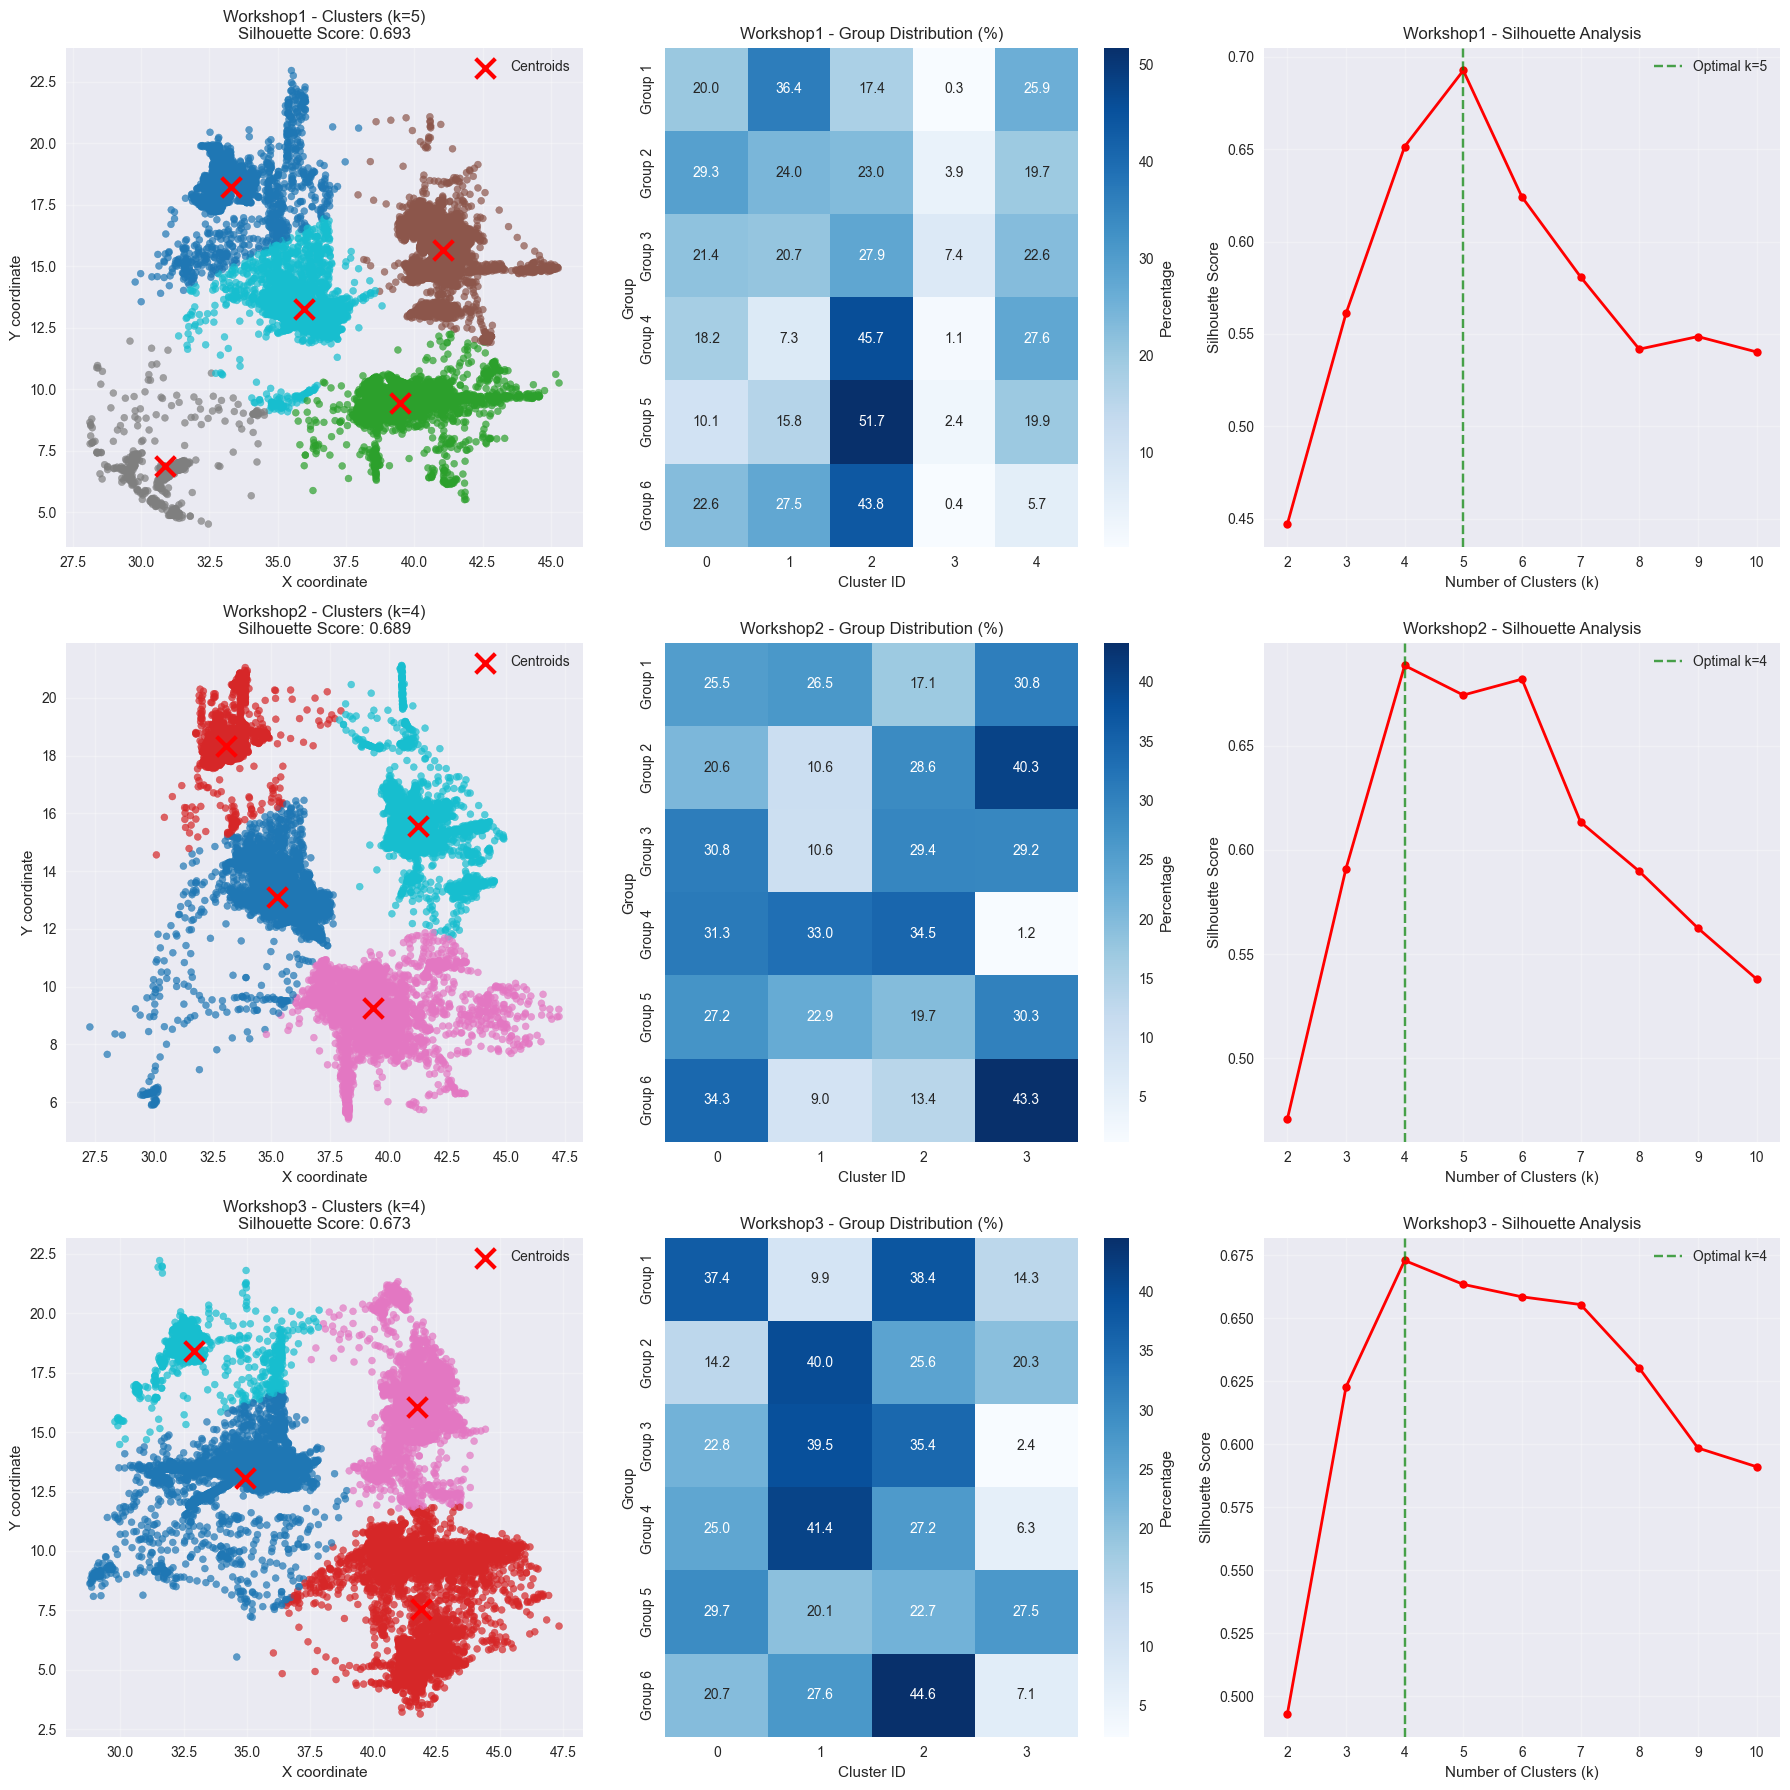

In [30]:
# Visualize individual workshop clustering results
def plot_workshop_clusters(workshop_results):
    """
    Create comprehensive visualizations for all workshops
    """
    num_workshops = len(workshop_results)
    fig, axes = plt.subplots(num_workshops, 3, figsize=(18, 6 * num_workshops))
    
    if num_workshops == 1:
        axes = axes.reshape(1, -1)
    
    workshop_names = sorted(workshop_results.keys())
    
    for i, workshop_name in enumerate(workshop_names):
        result = workshop_results[workshop_name]
        workshop_data = result['data']
        cluster_centers = result['cluster_centers']
        
        # Plot 1: Scatter plot with clusters
        scatter = axes[i, 0].scatter(workshop_data['x'], workshop_data['y'], 
                                   c=workshop_data['workshop_cluster'], 
                                   cmap='tab10', alpha=0.7, s=25)
        axes[i, 0].scatter(cluster_centers[:, 0], cluster_centers[:, 1], 
                          c='red', marker='x', s=200, linewidths=3, label='Centroids')
        axes[i, 0].set_title(f'{workshop_name} - Clusters (k={result["best_k"]})\nSilhouette Score: {result["best_silhouette"]:.3f}')
        axes[i, 0].set_xlabel('X coordinate')
        axes[i, 0].set_ylabel('Y coordinate')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)
        
        # Plot 2: Group distribution heatmap
        if len(result['group_cluster_table']) > 0:
            sns.heatmap(result['group_cluster_table'], annot=True, fmt='.1f', 
                       cmap='Blues', ax=axes[i, 1], cbar_kws={'label': 'Percentage'})
            axes[i, 1].set_title(f'{workshop_name} - Group Distribution (%)')
            axes[i, 1].set_xlabel('Cluster ID')
            axes[i, 1].set_ylabel('Group')
        
        # Plot 3: Silhouette analysis
        if result['k_range'] is not None:
            axes[i, 2].plot(result['k_range'], result['silhouette_scores'], 'ro-', linewidth=2, markersize=6)
            axes[i, 2].axvline(x=result['best_k'], color='green', linestyle='--', alpha=0.7, label=f'Optimal k={result["best_k"]}')
            axes[i, 2].set_title(f'{workshop_name} - Silhouette Analysis')
            axes[i, 2].set_xlabel('Number of Clusters (k)')
            axes[i, 2].set_ylabel('Silhouette Score')
            axes[i, 2].legend()
            axes[i, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create the visualizations
plot_workshop_clusters(workshop_results)

In [31]:
# Compare workshops side by side
print("\n" + "="*80)
print("WORKSHOP COMPARISON SUMMARY")
print("="*80)

comparison_data = []
for workshop_name, result in workshop_results.items():
    workshop_data = result['data']
    comparison_data.append({
        'Workshop': workshop_name,
        'Data Points': len(workshop_data),
        'Groups': len(workshop_data['name'].unique()),
        'Optimal Clusters': result['best_k'],
        'Silhouette Score': result['best_silhouette'],
        'X Range': f"{workshop_data['x'].min():.1f}-{workshop_data['x'].max():.1f}",
        'Y Range': f"{workshop_data['y'].min():.1f}-{workshop_data['y'].max():.1f}",
        'Duration (Hours)': round((workshop_data['time'].max() - workshop_data['time'].min()).total_seconds() / 3600, 1)
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 Workshop Comparison Table:")
print(comparison_df.to_string(index=False))

# Find most and least clustered workshops
best_workshop = comparison_df.loc[comparison_df['Silhouette Score'].idxmax(), 'Workshop']
worst_workshop = comparison_df.loc[comparison_df['Silhouette Score'].idxmin(), 'Workshop']
most_clusters = comparison_df.loc[comparison_df['Optimal Clusters'].idxmax(), 'Workshop']
least_clusters = comparison_df.loc[comparison_df['Optimal Clusters'].idxmin(), 'Workshop']

print(f"\n🏆 Key Findings:")
print(f"   • Best clustered workshop: {best_workshop} (highest silhouette score: {comparison_df['Silhouette Score'].max():.3f})")
print(f"   • Most complex workshop: {most_clusters} ({comparison_df['Optimal Clusters'].max()} clusters)")
print(f"   • Simplest workshop: {least_clusters} ({comparison_df['Optimal Clusters'].min()} clusters)")

# Analyze cluster center locations across workshops
print(f"\n📍 Cluster Centers Comparison:")
for workshop_name, result in workshop_results.items():
    print(f"\n{workshop_name}:")
    for i, center in enumerate(result['cluster_centers']):
        cluster_data = result['data'][result['data']['workshop_cluster'] == i]
        dominant_group = cluster_data['name'].mode().iloc[0] if len(cluster_data) > 0 else 'None'
        print(f"   • Cluster {i}: ({center[0]:.1f}, {center[1]:.1f}) - Dominant: {dominant_group}")

print("="*80)


WORKSHOP COMPARISON SUMMARY

📊 Workshop Comparison Table:
 Workshop  Data Points  Groups  Optimal Clusters  Silhouette Score   X Range  Y Range  Duration (Hours)
Workshop1        19905       6                 5          0.692518 28.1-45.3 4.5-22.9               2.9
Workshop2        17676       6                 4          0.688550 27.3-47.2 5.4-21.1               2.6
Workshop3        21939       6                 4          0.672889 28.8-47.4 3.1-22.2               4.1

🏆 Key Findings:
   • Best clustered workshop: Workshop1 (highest silhouette score: 0.693)
   • Most complex workshop: Workshop1 (5 clusters)
   • Simplest workshop: Workshop2 (4 clusters)

📍 Cluster Centers Comparison:

Workshop1:
   • Cluster 0: (33.3, 18.2) - Dominant: Group 2
   • Cluster 1: (39.5, 9.4) - Dominant: Group 1
   • Cluster 2: (41.0, 15.6) - Dominant: Group 3
   • Cluster 3: (30.9, 6.9) - Dominant: Group 3
   • Cluster 4: (36.0, 13.3) - Dominant: Group 3

Workshop2:
   • Cluster 0: (35.2, 13.1) - Dominan


GROUP MOVEMENT PATTERNS ACROSS WORKSHOPS

Group 1:
 Workshop  Data Points  Most Used Cluster  Concentration (%)  Clusters Used
Workshop1         3388                  1          36.422668              5
Workshop2         2960                  3          30.810811              4
Workshop3         3135                  2          38.405104              4

Group 2:
 Workshop  Data Points  Most Used Cluster  Concentration (%)  Clusters Used
Workshop1         5083                  0          29.293724              5
Workshop2         2014                  3          40.268123              4
Workshop3         5618                  1          39.978640              4

Group 3:
 Workshop  Data Points  Most Used Cluster  Concentration (%)  Clusters Used
Workshop1         5358                  2          27.864875              5
Workshop2         3798                  0          30.832017              4
Workshop3         3640                  1          39.450549              4

Group 4:
 Works

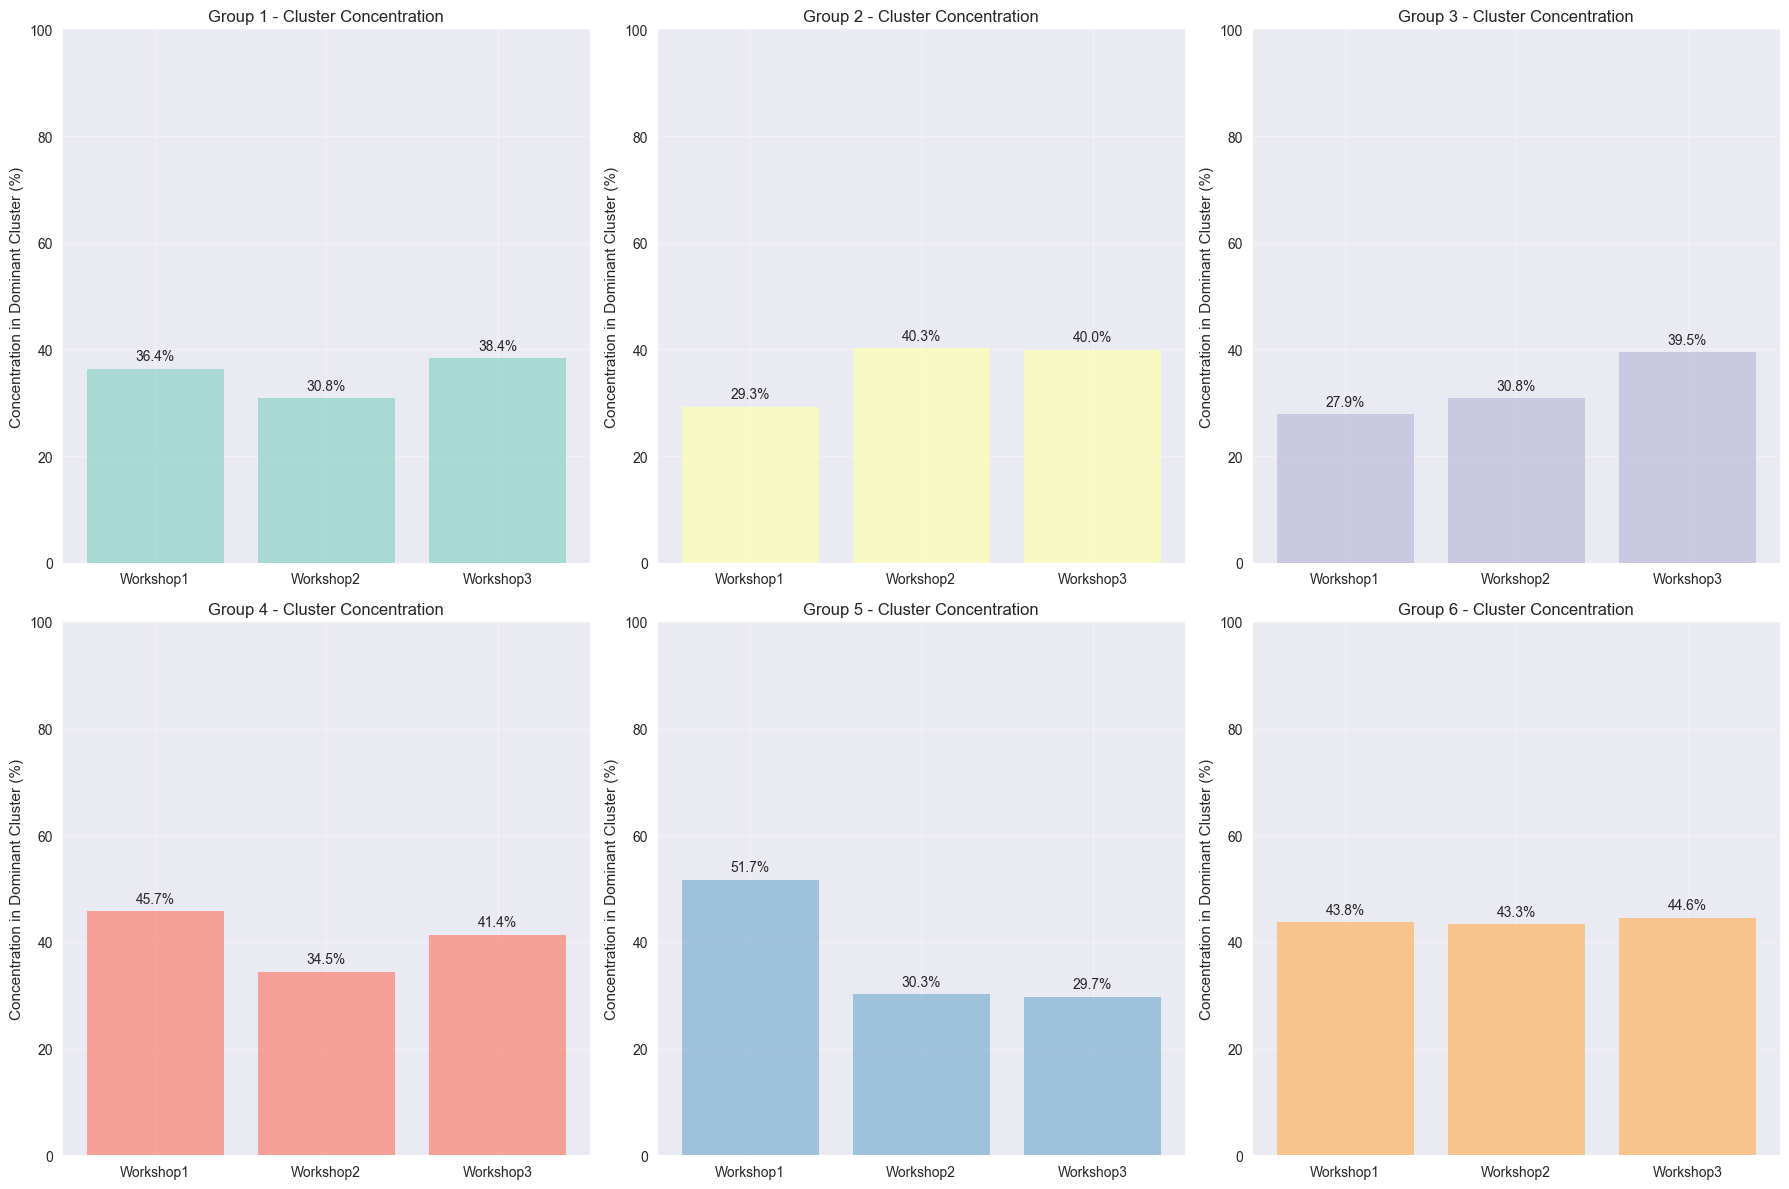


💡 Key Insights from Individual Workshop Analysis:
   • Each workshop shows distinct clustering patterns
   • Group behaviors vary significantly between workshops
   • Workshop complexity (number of clusters) ranges from 4 to 5
   • Clustering quality varies, with silhouette scores from 0.673 to 0.693
   • This suggests different activities, layouts, or group dynamics in each session


In [32]:
# Create a detailed group movement analysis across workshops
print("\n" + "="*80)
print("GROUP MOVEMENT PATTERNS ACROSS WORKSHOPS")
print("="*80)

# Analyze how each group behaves in different workshops
all_groups = sorted(combined_df['name'].unique())

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, group in enumerate(all_groups):
    if i >= len(axes):
        break
    
    group_workshop_data = []
    for workshop_name, result in workshop_results.items():
        workshop_data = result['data']
        group_data = workshop_data[workshop_data['name'] == group]
        
        if len(group_data) > 0:
            # Get cluster distribution for this group in this workshop
            cluster_dist = group_data['workshop_cluster'].value_counts(normalize=True).sort_index()
            most_used_cluster = cluster_dist.idxmax()
            cluster_concentration = cluster_dist.max() * 100
            
            group_workshop_data.append({
                'Workshop': workshop_name,
                'Data Points': len(group_data),
                'Most Used Cluster': most_used_cluster,
                'Concentration (%)': cluster_concentration,
                'Clusters Used': len(cluster_dist)
            })
    
    if group_workshop_data:
        group_df = pd.DataFrame(group_workshop_data)
        
        # Plot concentration percentages
        bars = axes[i].bar(group_df['Workshop'], group_df['Concentration (%)'], 
                          color=plt.cm.Set3(i), alpha=0.7)
        axes[i].set_title(f'{group} - Cluster Concentration')
        axes[i].set_ylabel('Concentration in Dominant Cluster (%)')
        axes[i].set_ylim(0, 100)
        axes[i].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, concentration in zip(bars, group_df['Concentration (%)']):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                        f'{concentration:.1f}%', ha='center', va='bottom', fontsize=10)
        
        print(f"\n{group}:")
        print(group_df.to_string(index=False))
    else:
        axes[i].text(0.5, 0.5, f'No data for {group}', ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'{group} - No Data')

# Hide empty subplots
for j in range(len(all_groups), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Summary insights
print(f"\n💡 Key Insights from Individual Workshop Analysis:")
print(f"   • Each workshop shows distinct clustering patterns")
print(f"   • Group behaviors vary significantly between workshops")
print(f"   • Workshop complexity (number of clusters) ranges from {comparison_df['Optimal Clusters'].min()} to {comparison_df['Optimal Clusters'].max()}")
print(f"   • Clustering quality varies, with silhouette scores from {comparison_df['Silhouette Score'].min():.3f} to {comparison_df['Silhouette Score'].max():.3f}")
print(f"   • This suggests different activities, layouts, or group dynamics in each session")

print("="*80)